# Sets Analysis

In [1]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import json
import seaborn as sns
import numpy as np
from matplotlib_venn import venn3, venn3_circles, venn2

## Subset of citations

In [2]:
all_citations = pd.read_csv('../inputdata/all_cases_citations.csv')
print('Total citations relations EUR-LEX: ',len(all_citations))

Total citations relations EUR-LEX:  43780


In [3]:
sampled_cases = pd.read_csv('../inputdata/sampled_cases.csv').rename(columns={'source':'case'})
print('Total sampled cases for the study: ',len(sampled_cases))

Total sampled cases for the study:  177


In [4]:
sampled_cases.head()

,quantile,case,citations,topic
0,1.00,61990CJ0006,43,social policy
1,1.00,62003CJ0453,32,public health
2,0.99,62007CJ0378,32,social policy
3,0.98,61995CJ0261,19,social policy
4,1.00,62000CJ0465,17,data protection


In [5]:
print(
len(sampled_cases[sampled_cases['topic']=='social policy']),
len(sampled_cases[sampled_cases['topic']=='public health']),
len(sampled_cases[sampled_cases['topic']=='data protection'])
)


85 63 29


---
## Functions 

In [6]:
#Creating all unique nodes of the graph (this nodes catakogue works for both graphs)
def df_to_json_nodes(df_relations, df_attributes, node_name = 'case'):
    """"Assumes the columns are called source and target"""
    nodes_list = []; nodes = pd.DataFrame()
    nodes_list.extend(list(df_relations.source))# .unique()))
    nodes_list.extend(list(df_relations.target))# .unique()))
    nodes[str(node_name)] = list(set(nodes_list))  # DataFrame index must be unique for orient='index'.
    nodes = pd.merge(nodes, df_attributes, how='left').fillna('NA')
    nodes = nodes.set_index(str(node_name)).to_dict('index')
    return nodes

In [7]:
#Get the graph and layout, works only for this dataset
def graph_and_layout(df, nodes):
    #Assumes the relations are called source and target
    g = nx.from_pandas_edgelist(df, 'source', 'target', edge_attr=True) #, create_using = nx.DiGraph)
    nx.set_node_attributes(g, nodes)
    return g

In [8]:
#Graph description
def graph_description(g):
    N_nodes, N_edges = g.order(), g.size()
    avg_deg = float(N_nodes)/N_edges
    print ('Nodes: {}\nEdges: {}\nAvg Degree: {}'.format(N_nodes, N_edges, avg_deg) )

In [9]:
#goupings the colors
def groups(g):
    group0 = []
    group1 = []
    group2 = []
    group3 = []
    for n in g.nodes():
        if g.node[str(n)]['topic'] == "NA":
            group0.append(n)
        elif g.node[str(n)]['topic'] == "social policy":
            group1.append(n)
        elif g.node[str(n)]['topic'] == "public health":
            group2.append(n)
        elif g.node[str(n)]['topic'] == "data protection":
            group3.append(n)
        else:
            print(n)
    return group0, group1, group2, group3

In [10]:
def plot_graph(g, pos, groups, edges_groups):
    plt.figure(figsize=(16, 12))
    nx.draw_networkx_nodes(g,pos,
                           nodelist=groups[0],
                           node_color="#878787", #gray
                           node_size=10,
                           linewidths = 3,
                           alpha=0.3)
    nx.draw_networkx_nodes(g,pos,
                           nodelist=groups[1],
                           node_color="#3f59bf", #blue "social policy"
                           node_size=30,
                           alpha=0.8)
    nx.draw_networkx_nodes(g,pos,
                           nodelist=groups[2],
                           node_color="#bfb71f",  #yellow "public health"
                           node_size=30,
                           alpha=0.8)
    nx.draw_networkx_nodes(g,pos,
                           nodelist=groups[3],
                           node_color="#3ecc0e", #green "data protection"
                           node_size=30,
                           alpha=0.8)
    nx.draw_networkx_edges(g,pos,
                           edgelist=edges_groups[0],
                           width=0.5,alpha=0.5,edge_color='gray')
    nx.draw_networkx_edges(g,pos,
                           edgelist=edges_groups[1],
                           width=1,alpha=0.8,edge_color='red')
    #nx.draw_networkx_edges(g,pos,width=0.5,alpha=0.5, arrows=False, arrowstyle="Arc3, rad=-0.2")
    plt.show()

---
## Citations Graph (gold standard table)

#### Taking the subset of the whole citations files where the target OR the source is in the sample

In [11]:
all_citations['source_in_sample'] = [1 if i in list(sampled_cases.case) else 0 for i in all_citations['source']]
all_citations['target_in_sample'] = [1 if i in list(sampled_cases.case) else 0 for i in all_citations['target']]

In [12]:
citations_subset = all_citations[(all_citations['source_in_sample'] == 1) | (all_citations['target_in_sample'] == 1)]

In [13]:
print('Total citations relations sampled from EUR-LEX: ',len(citations_subset))

Total citations relations sampled from EUR-LEX:  1174


In [14]:
#citations_subset = citations_subset[['source','target']]
citations_subset.head()

,source,target,source_in_sample,target_in_sample
188,62016CJ0384,61962CJ0025,1,0
286,62007CO0073,61964CO0006,1,0
334,61996CJ0416,61965CJ0061,1,0
404,61996CJ0050,61968CJ0014,1,0
535,61987CJ0187,61970CJ0009,1,0


---
#### Creating the citations graph

In [16]:
nodes = df_to_json_nodes(df_relations = citations_subset,
                         df_attributes = sampled_cases[['case','topic']])
g = graph_and_layout(citations_subset, nodes) #the df of relations again
pos = nx.spring_layout(g) #nx.kamada_kawai_layout(g2)
graph_description(g)

Nodes: 1031
Edges: 1172
Avg Degree: 0.8796928327645052


In [17]:
g_rest, g_SP, g_PH, g_DP = groups(g)

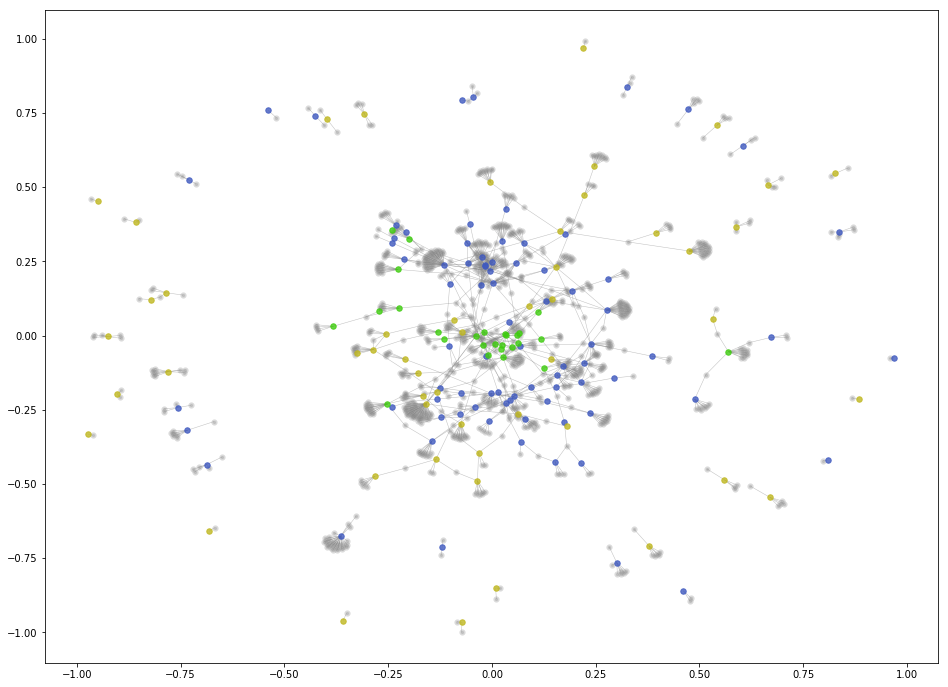

In [19]:
plot_graph(g,pos,
           [g_rest, g_SP, g_PH, g_DP],
           [[(s,t) for s, t, att in g.edges.data()],[]])

---
## Similarity Graph (from similarity table results)

#### Filtering relevant algorithmns

In [20]:
models = pd.read_csv('../inputdata/models.csv')
models

,Similarity Type,Similarity Method,Model,method
0,Syntactic,Index,N-grams (N=5),tfidf-quintgram-nostem
1,Syntactic,Index,Jaccard Distance,jaccard
2,Syntactic,Index,TF-IDF,tfidf-nostem
3,Semantic,Word Mover's Distance,GoogleNews Embeddings,GoogleNews-300-WMD
4,Semantic,Word Mover's Distance,Law2Vec Embeddings,Law2Vec-200-WMD
5,Semantic,Word Mover's Distance,EJC Embeddings,WMD_256_e30
6,Semantic,Cosine Similarity,EJC Embeddings,doc2vec_256_e30
7,Semantic,Cosine Similarity,Law2Vec Embeddings,law2vec_200
8,Semantic,Cosine Similarity,GoogleNews Embeddings,GoogleNews_300


In [186]:
cases_similarity = pd.read_csv('../outputdata/results.csv')\
    .drop(columns=['similarity_score'])\
    .rename(columns = {'source_case':'source', 'similar_case':'target'})
cases_similarity = cases_similarity[cases_similarity['method'].isin(list(models.method))]
cases_similarity['link'] = cases_similarity.source + '-' + cases_similarity.target
cases_similarity['similarity_link'] = True
cases_similarity.head()

,source,target,method,citation_link,source_case_topic,link,similarity_link
120360,62003CJ0453,62008CJ0222,law2vec_200,False,public health,62003CJ0453-62008CJ0222,True
120361,62003CJ0453,62008CJ0414,law2vec_200,False,public health,62003CJ0453-62008CJ0414,True
120362,62003CJ0453,62008CJ0141,law2vec_200,False,public health,62003CJ0453-62008CJ0141,True
120363,62003CJ0453,62009CJ0266,law2vec_200,False,public health,62003CJ0453-62009CJ0266,True
120364,62003CJ0453,62008CJ0211,law2vec_200,False,public health,62003CJ0453-62008CJ0211,True


In [187]:
## All methods should have the same total of cases
cases_similarity.groupby(['method']).count()['source'].reset_index().head()

,method,source
0,GoogleNews-300-WMD,3540
1,GoogleNews_300,3540
2,Law2Vec-200-WMD,3540
3,WMD_256_e30,3540
4,doc2vec_256_e30,3540


In [23]:
# #### Filtering top 5 similar

# #Take only the range of top 5 similar
# tops5 = []; m = int(round(len(casses_similarity)/20,0)); n = 20
# for n in list(range(0, (m)*n, n)):
#     tops5.append([i+n for i in [0,1,2,3,4]])
# tops5 = [item for s in tops5 for item in s]

# #len(tops5); tops5.reverse()

# cases_sim_sorted = casses_similarity.sort_values(
#     ['source','method','similarity_score'],ascending=False).reset_index()

# cases_similarity_top5 = cases_sim_sorted[cases_sim_sorted.index.isin(tops5)]

# ## All methods should have the same total of cases
# #cases_similarity_top5.groupby(['method']).count()['source'].reset_index().head(10)

# print('Total relations of cases similarity filtered from  EUR-LEX: ',len(cases_similarity_top5))

---
#### Creating the similarity graph

In [27]:
nodes2 = df_to_json_nodes(df_relations = cases_similarity,
                         df_attributes = sampled_cases[['case','topic']])
g2 = graph_and_layout(cases_similarity, nodes2) #the df of relations again
pos2 = nx.spring_layout(g2) #nx.kamada_kawai_layout(g2)
graph_description(g2)

Nodes: 8281
Edges: 20499
Avg Degree: 0.40397092541099566


In [28]:
g2_rest, g2_SP, g2_PH, g2_DP = groups(g2)

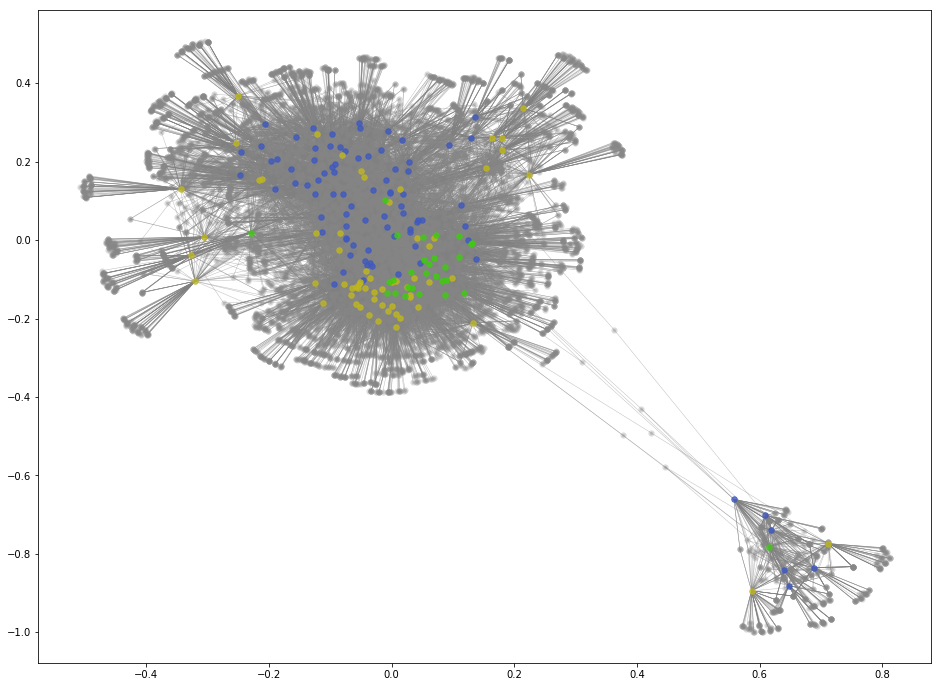

In [29]:
plot_graph(g2,pos2,
           [g2_rest, g2_SP, g2_PH, g2_DP ],
           [[(s,t) for s, t, att in g2.edges.data()],[]])

---
### Summary of Overlap of Links

In [30]:
## All methods should have the same total of cases
print(len(cases_similarity))
cases_similarity.groupby(['method']).count()['source'].reset_index().tail()

31860


,method,source
4,doc2vec_256_e30,3540
5,jaccard,3540
6,law2vec_200,3540
7,tfidf-nostem,3540
8,tfidf-quintgram-nostem,3540


#### 1. The size of unique links in the net of similarity is 3540

In [98]:
#Transformation of citations_subset, we want the outgoing and incoming links
citations_subset_S = citations_subset[citations_subset['source_in_sample'] == 1 ]
citations_subset_T = citations_subset[citations_subset['target_in_sample'] == 1 ]

citations_subset_S = citations_subset_S.reset_index()[['source','target']]
citations_subset_S['link_type'] = len(citations_subset_S)*['S'] #case in the left is source

citations_subset_T = citations_subset_T.reset_index()[['target','source']]\
    .rename(columns={'target':'source','source':'target'}) #swapping the colums for the cases where the sample is in the target
citations_subset_T['link_type'] = len(citations_subset_T)*['T'] #case in the left is target

citations_subset_filtered = citations_subset_S.append(citations_subset_T, ignore_index = True).drop_duplicates(['target','source'])

In [99]:
#We check wether if this universe are included in the unoverse of the dataset of similarity
is_case_similar = []
for index, row in citations_subset_filtered.iterrows():
     if row['target'] in list(cases_similarity['target']): #here target of cases_similarity_top5== similar to
            is_case_similar.append(row)
citations_subset_filtered = pd.DataFrame(is_case_similar)

In [100]:
citations_subset_filtered['link'] = citations_subset_filtered.source + '-' + citations_subset_filtered.target

In [101]:
citations_subset_filtered = pd.merge(citations_subset_filtered, 
         sampled_cases[['case','topic']]\
        .rename(columns={'case':'source', 'topic':'source_case_topic'}), how='left', on='source')

In [102]:
#uniqueness of each row
len(citations_subset_filtered) == len(citations_subset_filtered['link'].unique())

True

In [103]:
print('Original number of citations: {}\nRelevant citations: {}\nPercentage: {}'.format(len(citations_subset),
                                                                                         len(citations_subset_filtered),
                                                                                        round(100*len(citations_subset_filtered)/len(citations_subset),2)))

Original number of citations: 1174
Relevant citations: 1068
Percentage: 90.97


In [104]:
citations_subset_filtered.head()

,source,target,link_type,link,source_case_topic
0,62007CO0073,61964CO0006,S,62007CO0073-61964CO0006,data protection
1,61996CJ0416,61965CJ0061,S,61996CJ0416-61965CJ0061,social policy
2,61996CJ0050,61968CJ0014,S,61996CJ0050-61968CJ0014,social policy
3,61987CJ0187,61970CJ0009,S,61987CJ0187-61970CJ0009,public health
4,61987CJ0187,61970CJ0022,S,61987CJ0187-61970CJ0022,public health


#### 2. The size of unique links in the net of citations (which also appears in the net of similarity) is 1068

In [45]:
# temp = pd.merge(citations_subset_filtered
#          ,sampled_cases[['case','topic']].rename(columns={'case':'source'})
#          ,how='left', on='source')

# print('Taking top 20 we get: {}'.format(100*len(citations_subset_filtered)/len(len(citations_subset))))

# temp.groupby('topic').count()

In [46]:
#citations_subset_filtered.to_csv('test.csv')

### Selecting one method at the time to see the overlap in venn diagram

In [194]:
mainmethods = ['tfidf-quintgram-nostem',
               'jaccard',
               'tfidf-nostem',
               'GoogleNews-300-WMD',
               'doc2vec_256_e30',
               'law2vec_200',
               'GoogleNews_300',
               'WMD_256_e30',
               'Law2Vec-200-WMD',
              'NoMethod']

In [195]:
method = mainmethods[0]
method_table = cases_similarity[cases_similarity['method'] == method]

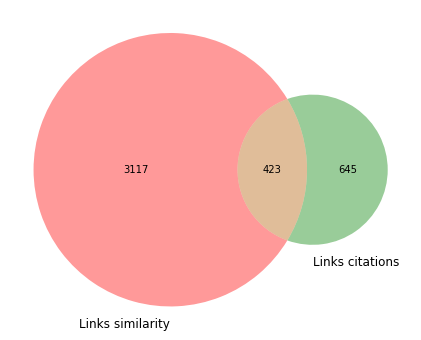

In [196]:
plt.figure(figsize=(8, 6))
venn2([set(method_table['link']), 
       set(citations_subset_filtered['link'])],
       set_labels = ('Links similarity', 'Links citations'),
       set_colors=('red', 'green')
)
plt.show()

We want the overlap of the yellow with the green

If we merge both tables then 2 conditions will give me the overlap  
#### citation_link = True  & method = NoMethod

In [109]:
len(cases_similarity)#.head(4)

31860

Finding what is outside the overlap so we add them to the dataset of similarity

In [105]:
list_citations_difference_ouside_overlap = \
    list(
    set(citations_subset_filtered.link)\
    - set(pd.merge(
    cases_similarity, 
    citations_subset_filtered, 
    how='inner', 
    on='link')\
          ['link'].unique()
         ))

In [106]:
citations_ouside_overlap = citations_subset_filtered[citations_subset_filtered['link']\
                        .isin(list_citations_difference_ouside_overlap)]\
                        .drop(columns=['link_type'])\
                        .reset_index(drop=True)

In [184]:
citations_ouside_overlap['method'] = 'NoMethod'
citations_ouside_overlap['citation_link'] = True
citations_ouside_overlap['similarity_link'] = False

In [185]:
len(citations_ouside_overlap)

479

#### Cases universe

In [188]:
cases_universe = cases_similarity.append(citations_ouside_overlap, ignore_index=True, sort=True)

In [189]:
cases_universe.tail()

,citation_link,link,method,similarity_link,source,source_case_topic,target
32334,True,62014CJ0362-62016CJ0426,NoMethod,False,62014CJ0362,data protection,62016CJ0426
32335,True,62016CJ0078-62016CJ0426,NoMethod,False,62016CJ0078,public health,62016CJ0426
32336,True,62016CO0508-62017CJ0111,NoMethod,False,62016CO0508,data protection,62017CJ0111
32337,True,62009CJ0447-62016CJ0574,NoMethod,False,62009CJ0447,social policy,62016CJ0574
32338,True,61996CJ0416-62009CJ0070,NoMethod,False,61996CJ0416,social policy,62009CJ0070


---

## Export working data to visualize

In [190]:
def export4visualization(table, path):
    models = pd.read_csv('../inputdata/models.csv')
    table = pd.merge(table, models, how='left', on='method')
    table[table.method.isin(mainmethods)]\
    .reset_index(drop=True)\
    .to_csv(path, index=False)
    print('Extported to {}'.format(path))

export4visualization(cases_universe, '../outputdata/results4plot.csv')

Extported to ../outputdata/results4plot.csv


In [191]:
results4plot = pd.read_csv('../outputdata/results4plot.csv')
results4plot.head(3)

,citation_link,link,method,similarity_link,source,source_case_topic,target,Similarity Type,Similarity Method,Model
0,False,62003CJ0453-62008CJ0222,law2vec_200,True,62003CJ0453,public health,62008CJ0222,Semantic,Cosine Similarity,Law2Vec Embeddings
1,False,62003CJ0453-62008CJ0414,law2vec_200,True,62003CJ0453,public health,62008CJ0414,Semantic,Cosine Similarity,Law2Vec Embeddings
2,False,62003CJ0453-62008CJ0141,law2vec_200,True,62003CJ0453,public health,62008CJ0141,Semantic,Cosine Similarity,Law2Vec Embeddings


In [192]:
results4plot\
    .groupby(['method'])\
    .count()['source']\
    .reset_index()\
    .sort_values('source', ascending=False)

,method,source
0,GoogleNews-300-WMD,3540
1,GoogleNews_300,3540
2,Law2Vec-200-WMD,3540
4,WMD_256_e30,3540
5,doc2vec_256_e30,3540
6,jaccard,3540
7,law2vec_200,3540
8,tfidf-nostem,3540
9,tfidf-quintgram-nostem,3540
3,NoMethod,479


---
## Visualizing overlap of methods

In [144]:
table = results4plot[results4plot['citation_link'] == True] #ONLY THE OVERLAP GROUP
groupA = table[(table['Similarity Type']=='Semantic') & (table['Similarity Method']=="Word Mover's Distance")]
groupB = table[(table['Similarity Type']=='Semantic') & (table['Similarity Method']=="Cosine Similarity")]
groupC = table[(table['Similarity Type']=='Syntactic')]

1068


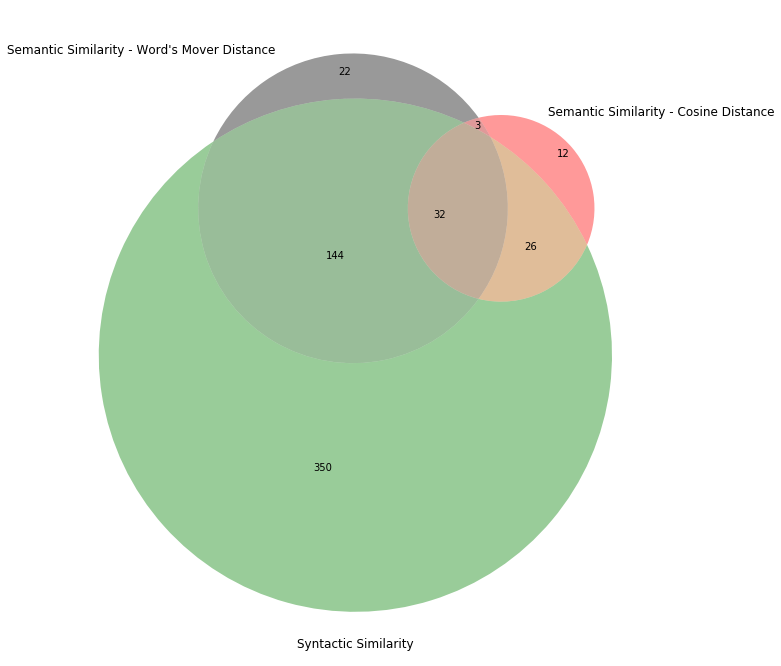

In [145]:
print(len(table['link'].unique()))
plt.figure(figsize=(16, 12))
venn3([set(groupA['link']), 
       set(groupB['link']),
      set(groupC['link'])], 
      set_labels = ("Semantic Similarity - Word's Mover Distance", 'Semantic Similarity - Cosine Distance', 'Syntactic Similarity'),
      set_colors=('black', 'r', 'green'))
plt.show()
#334 distinct

---
## Intersection Graph

In [197]:
#recallling the method
print(len(method_table))
method_table.head()

3540


,source,target,method,citation_link,source_case_topic,link,similarity_link
201780,62003CJ0453,62006CO0421,tfidf-quintgram-nostem,True,public health,62003CJ0453-62006CO0421,True
201781,62003CJ0453,61993CJ0465,tfidf-quintgram-nostem,True,public health,62003CJ0453-61993CJ0465,True
201782,62003CJ0453,61988CJ0143,tfidf-quintgram-nostem,True,public health,62003CJ0453-61988CJ0143,True
201783,62003CJ0453,61997CJ0269,tfidf-quintgram-nostem,True,public health,62003CJ0453-61997CJ0269,True
201784,62003CJ0453,62004CJ0479,tfidf-quintgram-nostem,True,public health,62003CJ0453-62004CJ0479,True


In [167]:
#Filtering only the links from the citations universe
method_table = method_table[method_table.link.isin(citations_subset_filtered.link)].reset_index(drop=True)

In [173]:
#len(cases_universe[(cases_universe['method']==mainmethods[3]) &
#              (cases_universe['citation_link']==True)])

In [198]:
method_table.method.unique()

array(['tfidf-quintgram-nostem'], dtype=object)

---
#### Creating the intersection graph

In [174]:
nodes3 = df_to_json_nodes(df_relations = method_table,
                         df_attributes = sampled_cases[['case','topic']])

g3 = graph_and_layout(method_table, nodes3) #the df of relations again
#pos3 = nx.spring_layout(g3)
pos3 = nx.kamada_kawai_layout(g3)
graph_description(g3)

Nodes: 425
Edges: 396
Avg Degree: 1.0732323232323233


In [175]:
g3_rest, g3_SP, g3_PH, g3_DP = groups(g3)

In [176]:
edges_citation = []
edges_similarity = []
for s, t, att in g3.edges.data():
    if (att['citation_link'] == True) & (att['method'] == method):
        edges_citation.append((s,t))
    else:
        edges_similarity.append((s,t))

In [177]:
len(edges_citation)

396

In [178]:
len(g3.edges)

396

In [179]:
print('Percentage of links overlap: ',len(edges_citation)/len(g3.edges))

Percentage of links overlap:  1.0


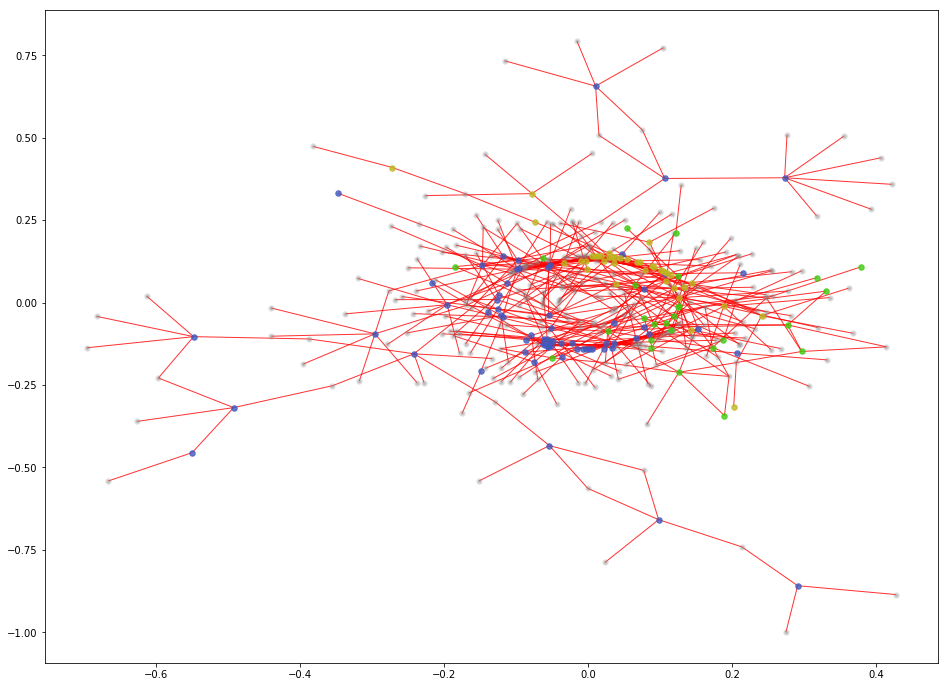

In [180]:
plot_graph(g3,pos3,
           [g3_rest, g3_SP, g3_PH, g3_DP],
           [edges_similarity,edges_citation])